In [1]:
%matplotlib inline


DCGAN Tutorial
==============

**Author**: `Nathan Inkawhich <https://github.com/inkawhich>`__




Introduction
------------

We will train a generative adversarial network (GAN) to generate new
tachikara basketballs after showing it pictures of many real ones. 

### Generative Adversarial Networks






In [2]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

plt.style.use('seaborn-notebook')
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


Inputs
------

Let’s define some inputs for the run:

-  **dataroot** - the path to the root of the dataset folder. We will
   talk more about the dataset in the next section
-  **workers** - the number of worker threads for loading the data with
   the DataLoader
-  **batch_size** - the batch size used in training. The DCGAN paper
   uses a batch size of 128
-  **image_size** - the spatial size of the images used for training.
   This implementation defaults to 64x64. If another size is desired,
   the structures of D and G must be changed. See
   `here <https://github.com/pytorch/examples/issues/70>`__ for more
   details
-  **nc** - number of color channels in the input images. For color
   images this is 3
-  **nz** - length of latent vector
-  **ngf** - relates to the depth of feature maps carried through the
   generator
-  **ndf** - sets the depth of feature maps propagated through the
   discriminator
-  **num_epochs** - number of training epochs to run. Training for
   longer will probably lead to better results but will also take much
   longer
-  **lr** - learning rate for training. As described in the DCGAN paper,
   this number should be 0.0002
-  **beta1** - beta1 hyperparameter for Adam optimizers. As described in
   paper, this number should be 0.5
-  **ngpu** - number of GPUs available. If this is 0, code will run in
   CPU mode. If this number is greater than 0 it will run on that number
   of GPUs




In [3]:
# Root directory for dataset
dataroot = ".\\data\\"

# Number of workers for dataloader
workers = 0

# Batch size during training
batch_size = 32

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size= 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 70
# Learning rate for optimizers
lr = 0.001

# Beta1 hyperparam for Adam optimizers
beta1 = 0.1

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

Custom Data
----
This is an important step because we will be using the ImageFolder
dataset class, which requires there to be subdirectories in the
dataset’s root folder. 

/data/Tachikara/1.jpg, 2.jpg, 3.jpg, ...

Now, we can create the dataset, create the
dataloader, set the device to run on, and finally

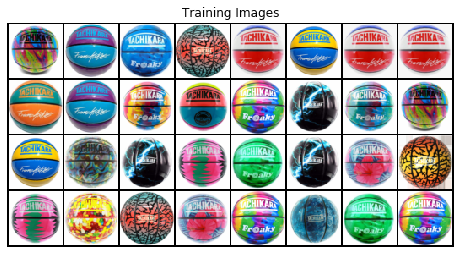

In [4]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:32], padding=2, normalize=True).cpu(),(1,2,0)))

Implementation
--------------

Weight Initialization
~~~~~~~~~~~~~~~~~~~~~

From the DCGAN paper, the authors specify that all model weights shall
be randomly initialized from a Normal distribution with mean=0,
stdev=0.02




In [5]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator

<img src="https://pytorch.org/tutorials/_images/dcgan_generator.png" width="500" height="500" />

- *nz* : the length of the z input vector
- *ngf* : the size of the feature maps that are propagated through the generator
- *nc* : the number of channels in the output image (set to 3 for RGB images)


In [6]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

Now, we can instantiate the generator and apply the ``weights_init``
function. 

Check out the architecture of generator object




### Discriminator

In [7]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

Now, as with the generator, we can create the discriminator, apply the
``weights_init`` functio

Check out the architecture of discriminator object

In [8]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
    netD = nn.DataParallel(netD, list(range(ngpu)))


# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [9]:
# Print the model
print(netG)
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


### Loss Functions and Optimizers

- Loss Functions:We will use the Binary Cross Entropy loss


- Optimizers  Adam with learning rate 0.0002 and Beta1 = 0.5


In [10]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))




### Training Loop


Starting Training Loop...


C:\Users\Silence\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:498: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[0/70][0/96]	Loss_D: 2.3931	Loss_G: 24.4359	D(x): 0.4790	D(G(z)): 0.7249 / 0.0000
[0/70][50/96]	Loss_D: 1.3557	Loss_G: 13.9972	D(x): 0.9815	D(G(z)): 0.4830 / 0.0000
[1/70][0/96]	Loss_D: 0.7420	Loss_G: 5.7021	D(x): 0.9869	D(G(z)): 0.4567 / 0.0162
[1/70][50/96]	Loss_D: 0.5711	Loss_G: 5.9386	D(x): 0.9749	D(G(z)): 0.3641 / 0.0071
[2/70][0/96]	Loss_D: 0.4570	Loss_G: 5.6984	D(x): 0.9048	D(G(z)): 0.2311 / 0.0066
[2/70][50/96]	Loss_D: 0.8681	Loss_G: 13.7310	D(x): 0.9161	D(G(z)): 0.4687 / 0.0000
[3/70][0/96]	Loss_D: 0.2990	Loss_G: 9.3550	D(x): 0.9810	D(G(z)): 0.1954 / 0.0005
[3/70][50/96]	Loss_D: 1.0185	Loss_G: 5.5077	D(x): 0.4891	D(G(z)): 0.0002 / 0.0131
[4/70][0/96]	Loss_D: 0.3328	Loss_G: 4.1244	D(x): 0.7507	D(G(z)): 0.0119 / 0.0495
[4/70][50/96]	Loss_D: 0.2878	Loss_G: 7.0636	D(x): 0.8707	D(G(z)): 0.0962 / 0.0081
[5/70][0/96]	Loss_D: 0.2032	Loss_G: 3.5331	D(x): 0.8906	D(G(z)): 0.0268 / 0.1223
[5/70][50/96]	Loss_D: 0.0118	Loss_G: 6.5306	D(x): 0.9907	D(G(z)): 0.0024 / 0.0026
[6/70][0/96]	Loss_D

[50/70][0/96]	Loss_D: 0.0659	Loss_G: 4.9417	D(x): 0.9987	D(G(z)): 0.0599 / 0.0141
[50/70][50/96]	Loss_D: 1.5396	Loss_G: 2.4073	D(x): 0.6385	D(G(z)): 0.0239 / 0.3604
[51/70][0/96]	Loss_D: 0.0085	Loss_G: 6.7022	D(x): 0.9977	D(G(z)): 0.0061 / 0.0043
[51/70][50/96]	Loss_D: 0.0180	Loss_G: 7.5942	D(x): 0.9931	D(G(z)): 0.0105 / 0.0025
[52/70][0/96]	Loss_D: 0.0536	Loss_G: 5.3539	D(x): 0.9535	D(G(z)): 0.0036 / 0.0268
[52/70][50/96]	Loss_D: 0.6003	Loss_G: 12.7188	D(x): 0.9997	D(G(z)): 0.3364 / 0.0003
[53/70][0/96]	Loss_D: 0.0221	Loss_G: 6.3032	D(x): 0.9867	D(G(z)): 0.0083 / 0.0058
[53/70][50/96]	Loss_D: 0.0286	Loss_G: 5.6854	D(x): 0.9999	D(G(z)): 0.0274 / 0.0064
[54/70][0/96]	Loss_D: 0.0039	Loss_G: 7.4829	D(x): 0.9992	D(G(z)): 0.0031 / 0.0024
[54/70][50/96]	Loss_D: 2.1929	Loss_G: 12.0245	D(x): 0.9999	D(G(z)): 0.5176 / 0.0015
[55/70][0/96]	Loss_D: 0.0433	Loss_G: 5.9047	D(x): 0.9953	D(G(z)): 0.0339 / 0.0065
[55/70][50/96]	Loss_D: 0.0170	Loss_G: 6.6380	D(x): 0.9898	D(G(z)): 0.0060 / 0.0039
[56/70][

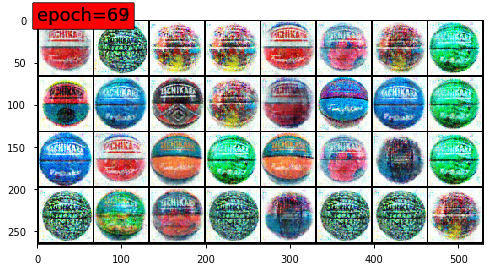

In [11]:

# Lists to keep track of progress
img_list = []
epoch_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)

        # Forward pass real batch through D
        output = netD(real_cpu)
#         print('output:',output)

       
        
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
       
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            plt.text(0, 0, 'epoch='+str(epoch),  fontsize=18, bbox=dict(facecolor='red', alpha=0.5))
            plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True),(1,2,0)))
            plt.savefig('fake_'+str(iters)+'.png')
            epoch_list.append(epoch)
            
            
        iters += 1 

Results
-------

Finally, lets check out how we did. Here, we will look at three
different results. First, we will see how D and G’s losses changed
during training. Second, we will visualize G’s output on the fixed_noise
batch for every epoch. And third, we will look at a batch of real data
next to a batch of fake data from G.

**Loss versus training iteration**

Below is a plot of D & G’s losses versus training iterations.




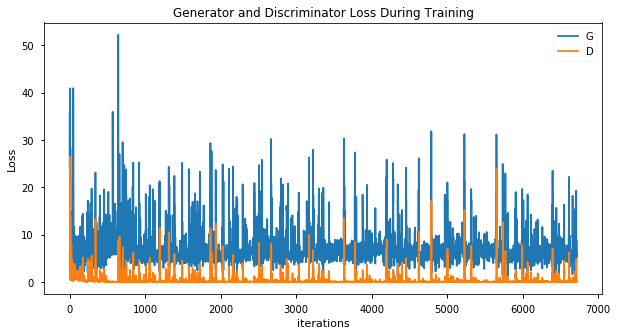

In [12]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Visualization of G’s progression**

Remember how we saved the generator’s output on the fixed_noise batch
after every epoch of training. Now, we can visualize the training
progression of G with an animation. Press the play button to start the
animation.




C:\Users\Silence\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


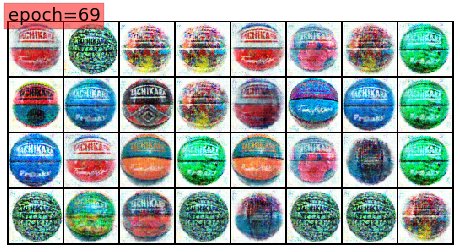

In [13]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ax = fig.add_subplot(111)

# ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]

ims=[]
index=0
for i in img_list:
    
    frame = ax.imshow(np.transpose(i,(1,2,0)) )
    text = ax.text(0, 0, 'epoch='+str(epoch_list[index]),  fontsize=18, bbox=dict(facecolor='red', alpha=0.5))

    ims.append([frame,text]) # add both the image and the text to the list of artists 
    index+=1


ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
ani.save('im.mp4', writer=writer)


HTML(ani.to_jshtml())

**Real Images vs. Fake Images**

Finally, lets take a look at some real images and fake images side by
side.




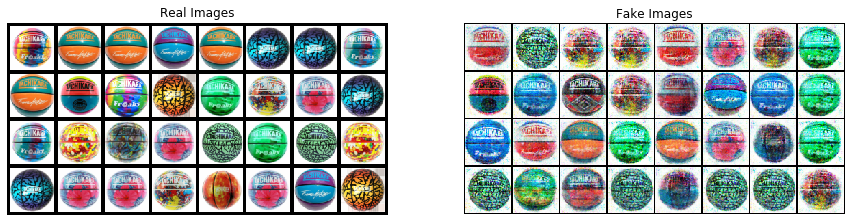

In [14]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:32], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

### Generate New Fake Data

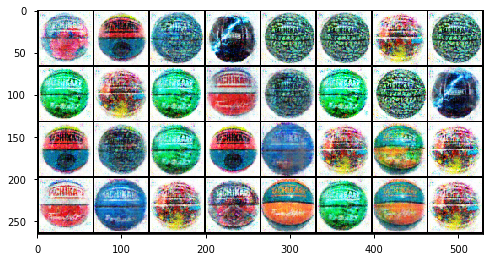

In [16]:
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)
fake = netG(fixed_noise).detach().cpu()
plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True),(1,2,0)))